<div style="background-color: darkred; padding: 10px; color: white;">

# Soma Proposal Generation 

</div>

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 1: Proposal Generation in a Single Image Patch

<div style="font-size: 17px;">
    In this section, we provide an overview of the main routines used to generate soma proposals within a single image patch. The proposal generation process follows the algorithm outlined below:
    <br><br>

<pre style="background-color: darkblue; color: white; font-family: monospace;">
    Soma Proposal Generation Algorithm
        1. Detect initial proposals - detect_blobs()
            a. Smooth image with Gaussian filter to reduce false positives.
            b. Laplacian of Gaussian to enhance regions where the intensity
               changes dramatically (i.e. higher gradient).
            c. Apply non-linear maximum filter over result from Step 1b, then
               generate initial set of proposals by detecting local maximas.
            d. Adjust each proposal by moving it to the brightest voxel in a
               small neighborhood centered the proposal. If the brightness at
               this voxel is below a certain threshold, then the proposal is
               is rejected.

        2. Filter proposals - filter_proposals()
            a. Sort proposals by brightness (i.e. high to low), then iterate
               over proposals and perform Steps 2b-2d.
            b. Check whether proposal is outside of image margins and has not
               been visited.
            c. Fit Gaussian to neighborhood centered at proposal, then check
               the fit quality by comparing Gaussian and image values. In
               addition, we check that the estimated standard deviation is
               above a threshold since there is a prior on the size of a soma.
            d. If a proposal satisfies the criteria from Step 2c, then it is
               kept and all proposals within a certain distance are discarded.
               
</pre>
</div>
</div>

### Imports


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from random import sample
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter, gaussian_laplace, maximum_filter
from scipy.optimize import curve_fit
from scipy.spatial import KDTree
from time import time
from tifffile import imwrite

from aind_exaspim_soma_detection import soma_proposal_generation as spg
from aind_exaspim_soma_detection.utils import img_util, util

%matplotlib inline


### Subroutines

In [2]:
def detect_blobs(img_patch, bright_threshold, LoG_sigma):
    # Preprocess image
    smoothed = gaussian_filter(img_patch, sigma=0.5)
    LoG = gaussian_laplace(smoothed, LoG_sigma)
    max_LoG = maximum_filter(LoG, 6)

    # Detect local maximas
    peaks = list()
    for peak in peak_local_max(max_LoG, min_distance=6):
        peak = tuple([int(x) for x in peak])
        if LoG[peak] > 0:
            peaks.append(peak)
    return spg.adjust_by_brightness(img_patch, peaks, bright_threshold), LoG


def filter_proposals(img_patch, proposals, margin, radius=6):
    # Initializations
    if len(proposals) > 0:
        kdtree = KDTree(proposals)
    else:
        return list(), list()

    # Main
    filtered_proposals = list()
    discared_proposals = list()
    visited = set()
    for idx in np.argsort([img_patch[p] for p in proposals])[::-1]:
        # Determine whether to visit proposal
        inbounds_bool = spg.is_inbounds(img_patch, proposals[idx], margin)
        not_visited_bool = proposals[idx] not in visited
        if inbounds_bool and not_visited_bool:
            # Fit Gaussian
            proposal = tuple([int(v) for v in proposals[idx]])
            fit, params = spg.gaussian_fitness(img_patch, proposal, radius=radius)
            mean, std = params[0:3], params[3:6]

            # Check whether to filter
            feasible_std = all(std > 0.4) and np.mean(std) > 0.6
            if fit > 0.8 and feasible_std:
                proposal = [proposal[i] + mean[i] - radius for i in range(3)]
                filtered_proposals.append(tuple(proposal))
                spg.discard_nearby(kdtree, visited, proposal)
            else:
                discared_proposals.append(proposal)
    return filtered_proposals, discared_proposals


def get_detections_img(shape, voxels):
    detections_img = np.zeros(shape)
    for voxel in voxels:
        voxel = tuple([int(v) for v in voxel])
        detections_img = img_util.mark_voxel(detections_img, voxel)
    return detections_img


### Initializations

In [3]:
# Parameters
bucket_name = "aind-open-data"
brain_id = "730902"
multiscale = 4

bright_threshold = 160
LoG_sigma = 4.5
d = 16  # image margin

# Open img
name_lookup = util.read_json("/root/capsule/data/exaspim_image_names.json")
prefix = f"s3://{bucket_name}/{name_lookup[brain_id]}/fused.zarr/{multiscale}"
img = img_util.open_img(prefix)
print("Image Shape:", img.shape)


Image Shape: (1, 1, 1823, 1818, 3917)


### Main

# Proposals: 3
# Rejects: 12
Runtime: 0.9991452693939209


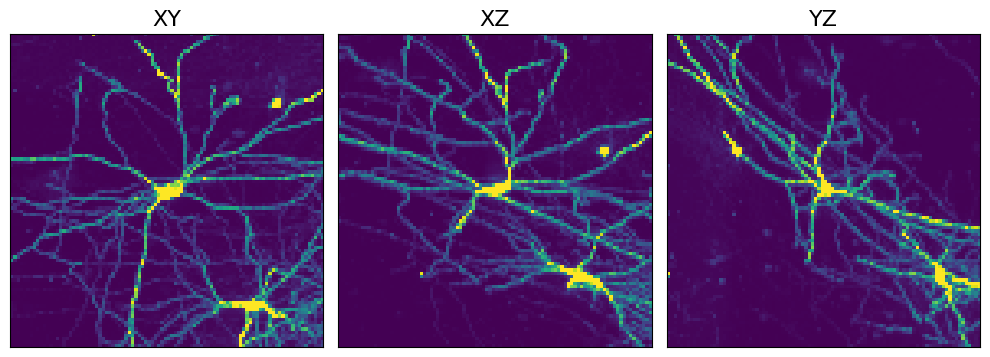

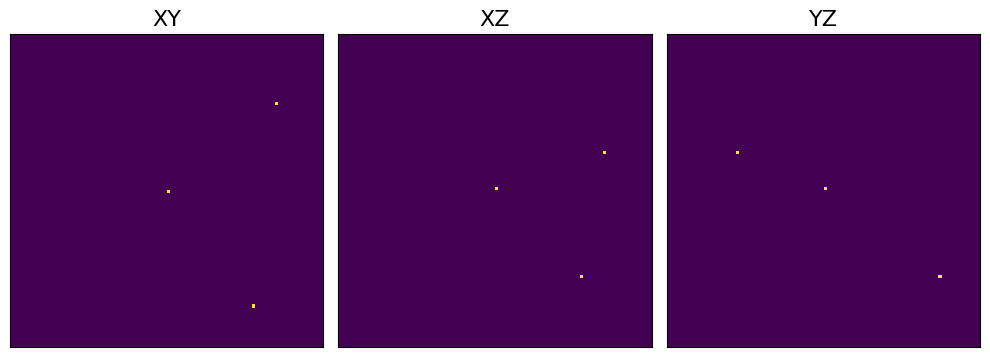

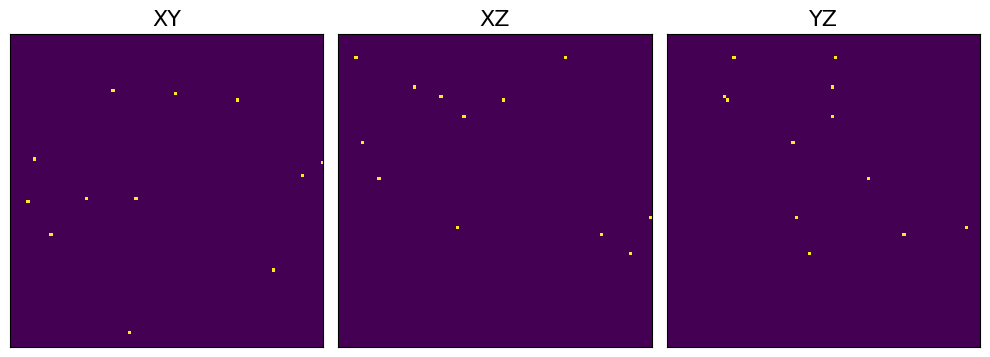

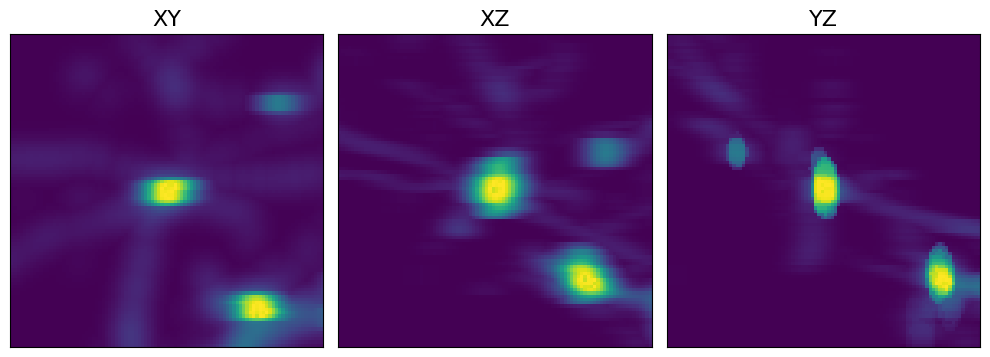

In [4]:
# Region of interest
xyz = [30868.83,15276.889,7985.6714]
shape = [128, 128, 128]

# Read image patch
voxel = img_util.to_voxels(xyz, multiscale=multiscale)
img_patch = spg.get_patch(img, voxel, shape, from_center=True)

# Proposal generation
t0 = time()
propsals, LoG_img_patch = detect_blobs(img_patch, bright_threshold, LoG_sigma)
proposals, rejects = filter_proposals(img_patch, propsals, d, radius=6)

print("# Proposals:", len(proposals))
print("# Rejects:", len(rejects))
print("Runtime:", time() - t0)

# Visualize Results
proposals_img = get_detections_img(img_patch.shape, proposals)
rejects_img = get_detections_img(img_patch.shape, rejects)

img_util.plot_mips(img_patch[d:-d, d:-d, d:-d], clip_bool=True)
img_util.plot_mips(proposals_img[d:-d, d:-d, d:-d])
img_util.plot_mips(rejects_img[d:-d, d:-d, d:-d])
img_util.plot_mips(LoG_img_patch[d:-d, d:-d, d:-d])

# Save Results
imwrite("img_patch.tiff", img_patch[d:-d, d:-d, d:-d])
imwrite("proposals.tiff", proposals_img[d:-d, d:-d, d:-d])
imwrite("rejects.tiff", rejects_img[d:-d, d:-d, d:-d])

### Visualize Gaussian Fit

Fitness Score: 0.5147765704194547
Parameters: [  6.82876552   6.58539572   6.97090469   0.77919773   0.52013091
   1.82245775 293.92807179  12.73788701]


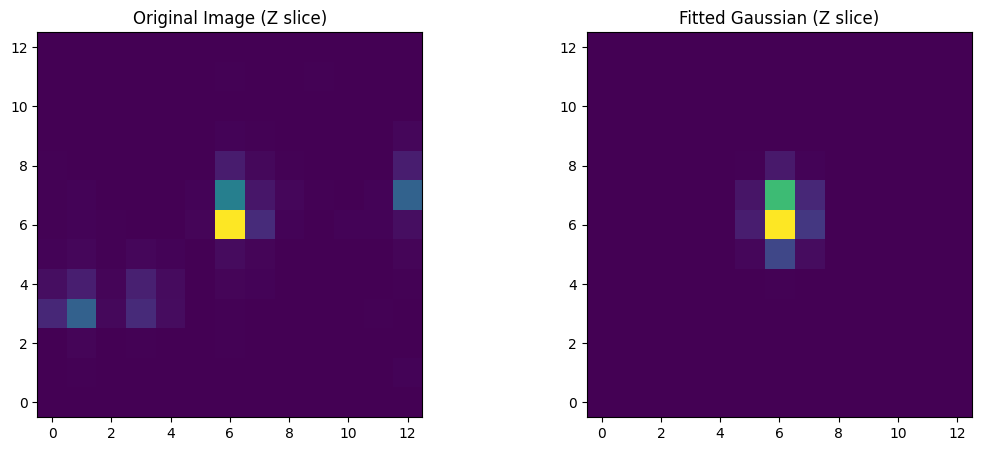

In [5]:
# Parameters
margin = 16
radius = 6

# Get valid center
while True:
    center = sample(proposals + rejects, 1)[0]
    if spg.is_inbounds(img_patch, center, margin=margin):
        break

# Get patch from img
x0, y0, z0 = tuple(map(int, center))
x_min, x_max = max(0, x0 - radius), min(img_patch.shape[0], x0 + radius + 1)
y_min, y_max = max(0, y0 - radius), min(img_patch.shape[1], y0 + radius + 1)
z_min, z_max = max(0, z0 - radius), min(img_patch.shape[2], z0 + radius + 1)
subpatch = img_patch[x_min:x_max, y_min:y_max, z_min:z_max]
img_vals = subpatch.ravel()

# Generate coordinates
xyz = [np.linspace(0, subpatch.shape[i], subpatch.shape[i]) for i in range(3)]
x, y, z = np.meshgrid(xyz[0], xyz[1], xyz[2], indexing='ij')
xyz = (x.ravel(), y.ravel(), z.ravel())

# Fit Gaussian
try:
    shape = subpatch.shape
    x0, y0, z0 = shape[0] // 2, shape[1] // 2, shape[2] // 2
    p0 = (x0, y0, z0, 2, 2, 2, np.max(subpatch), np.min(subpatch))
    params, _ = curve_fit(spg.gaussian_3d, xyz, img_vals, p0=p0)
except RuntimeError:
    pass

# Fitness quality
fitness_score = spg.fitness_quality(subpatch, xyz, params)
print("Fitness Score:", fitness_score)
print("Parameters:", params)

# Visualize image patch
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].imshow(subpatch[:, :, z0], cmap='viridis', origin='lower')
axs[0].set_title("Original Image (Z slice)")

# Visualize fitted gaussian
if params is not None:
    fitted_blob = spg.gaussian_3d((x, y, z), *params).reshape(x.shape)
    axs[1].imshow(fitted_blob[:, :, z0], cmap='viridis', origin='lower')
    axs[1].set_title("Fitted Gaussian (Z slice)")


In [6]:
stop

NameError: name 'stop' is not defined

<div style="background-color: darkblue; padding: 10px; color: white;">

## Section 2: Proposal Generation in Whole Brain

<div style="font-size: 17px;">
    In this section, we provide an overview of the main routines used to generate soma proposals on the scale of a whole brain.

</div>

### Imports

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

### Main

In [ ]:
# Parameters
margin = 16
overlap = (36, 36, 36)
patch_shape = (128, 128, 128)

bright_threshold = 200
LoG_sigma = 6
save_results = False

# Initializations
output_dir = "/root/capsule/results/soma_proposals"
offsets = img_util.sliding_window_coords_3d(img, patch_shape, overlap)
print("# Image Patches:", len(offsets))

# Proposal generation
t0 = time()
with ThreadPoolExecutor() as executor:
    # Assign threads
    threads = list()
    for offset in offsets[0:1000]:
        threads.append(
            executor.submit(
                spg.generate_proposals,
                img,
                offset,
                margin,
                patch_shape,
                multiscale,
                bright_threshold,
                LoG_sigma,
            )
        )

    # Process results
    proposals = list()
    pbar = tqdm(total=len(threads))
    for thread in as_completed(threads):
        proposals.extend(thread.result())
        pbar.update(1)

# Global filtering
proposals = spg.global_filtering(proposals)
print("# Proposals Generated:", len(proposals))
print("Runtime:", time() - t0)

# Save results (if applicable)
if save_results:
    util.mkdir(output_dir, delete=True)
    util.write_points(output_dir, proposals, color="0.0 0.0 1.0", prefix="proposal_")